# Tutorial 04: Implementing an analytical module for an X-ray component to allow gradient descent

### **What You Will Need**
- **Parameters**: $a, b, c, \dots$ to be estimated or optimized. 
- **An analtyical model**: $S(E; a, b, c, \dots)$ that defines the spectrum or energy response.  

### **What You Will Expect**
- How to build an **analtyical model**?
- Implementing the model using **PyTorch** for differentiability.
- A step-by-step guide to setting up and testing the interpolation module.

## A. Analytical Model of Filter
### A1. Background

In X-ray systems, filters are always used to protect the detector and enhance image quality by selectively absorbing low-energy X-rays that contribute to image noise without improving image contrast. According to Beer's law, the response of a single filter is

$$
f\left(E; m, \theta\right) = \mathrm{e}^{-\mu(E, m) \theta}
$$

where:

- $m$ denotes the filter material, which is a discrete parameter with only a limited set of choices. 
- $\mu(E, m)$ is the Linear Attenuation Coefficient (LAC) of material $m$ at energy $E$.
- $\theta$ denotes filter thickness, which is a continuous parameter within a continuous range.

### **A2. Step-by-Step Implementation**

To build an analytical model that supports **gradient descent**, we need two key functions:

1. **`__init__` (Initialize the Model)**  
   - Defines **materials** and **thickness** as model parameters.  
   - Assigns **separate memory for continuous parameters** corresponding to each discrete material selection.  
   - Enables **search over all material combinations**, allowing the model to explore different discrete parameter configurations.

2. **`forward` (Compute Filter Response)**  
   - Retrieves the current **material** and **thickness** for the filter. 
   - Calls `gen_fltr_res()` to compute the **X-ray attenuation response** using Beer's Law.  
   - Ensures the response is computed for a given set of **X-ray energies**.  

This setup enables **efficient spectral modeling and optimization** using PyTorch.


#### **Note 1: Material Class Overview**  

The `Material` class stores the **chemical formula** and **density** of a material, ensuring valid input types and allowing it to be used in X-ray modeling and optimization.

#### **Note 2: Get LAC value**
The `get_lin_att_c_vs_E` function calculates the linear attenuation coefficient (LAC) value with density, thickness, and energy vector.

#### **Note 3: `get_params()` Function Overview**  

The `get_params()` function, defined in `Base_Spec_Model`, retrieves the **estimated parameters** as a dictionary, applying **denormalization and clamping** to ensure they remain within valid bounds while maintaining gradient flow for optimization.

In [1]:
import numpy as np
import torch
from xcal.models import Base_Spec_Model
from xcal.defs import Material
from xcal.chem_consts._consts_from_table import get_lin_att_c_vs_E

# Implement the analytical model for filter.
def _obtain_attenuation(energies, formula, density, thickness, torch_mode=False):
    # thickness is mm
	mu = get_lin_att_c_vs_E(density, formula, energies)
	if torch_mode:
		mu = torch.tensor(mu)
		att = torch.exp(-mu * thickness)
	else:
		att = np.exp(-mu * thickness)
	return att

def gen_fltr_res(energies, fltr_mat:Material, fltr_th:float, torch_mode=True):

    return _obtain_attenuation(energies, fltr_mat.formula, fltr_mat.density, fltr_th, torch_mode)

# Gradient descent module.
class Filter(Base_Spec_Model):
    def __init__(self, materials, thickness):
        """
        A template filter model based on Beer's Law and NIST mass attenuation coefficients, including all necessary methods.

        Args:
            materials (list): A list of possible materials for the filter,
                where each material should be an instance containing formula and density.
            thickness (tuple or list): If a tuple, it should be (initial value, lower bound, upper bound) for the filter thickness.
                If a list, it should have the same length as the materials list, specifying thickness for each material.
                These values cannot be all None. It will not be optimized when lower == upper.
        """
        if isinstance(thickness, tuple):
            if all(t is None for t in thickness):
                raise ValueError("Thickness tuple cannot have all None values.")
            params_list = [{'material': mat, 'thickness': thickness} for mat in materials]
        elif isinstance(thickness, list):
            if len(thickness) != len(materials):
                raise ValueError("Length of thickness list must match length of materials list.")
            params_list = [{'material': mat, 'thickness': th} for mat, th in zip(materials, thickness)]
        else:
            raise TypeError("Thickness must be either a tuple or a list.")

        super().__init__(params_list)

    def forward(self, energies):
        """
        Takes X-ray energies and returns the filter response.

        Args:
            energies (torch.Tensor): A tensor containing the X-ray energies of a poly-energetic source in units of keV.

        Returns:
            torch.Tensor: The filter response as a function of input energies, selected material, and its thickness.
        """
		# Retrieves 
        mat = self.get_params()[f"{self.prefix}_material"]
        th = self.get_params()[f"{self.prefix}_thickness"]
        energies = torch.tensor(energies, dtype=torch.float32) if not isinstance(energies, torch.Tensor) else energies		
        return gen_fltr_res(energies, mat, th)


{'Filter_1_material': Material(formula='Al', density=2.702), 'Filter_1_thickness': tensor(2.5000, grad_fn=<ClampFunctionBackward>)}


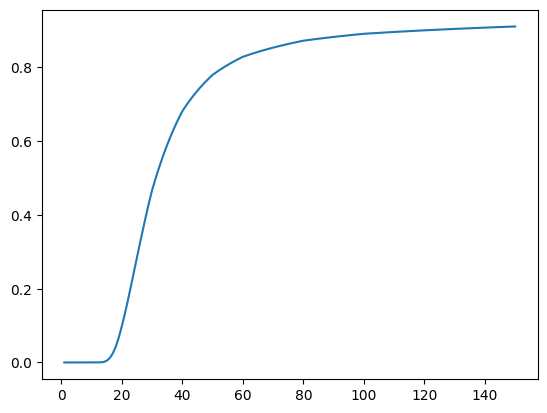

In [2]:
import matplotlib.pyplot as plt

gt_fltr_th = 2.5 # target thickness in um

psb_fltr_mat = [Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(gt_fltr_th, 0, 10))

ee = np.linspace(1,150,150)
ff = filter_1(ee)
est_param = filter_1.get_params()
print(f'{est_param}')

plt.plot(ee, ff.data)

# B. An Example of Estimating Filter Thickness

## B1. Data Simulation

In [3]:
max_simkV = 50 # keV
takeoff_angle = 13 # degree
mas_list = 0.01 # Milliampere-seconds

fltr_mat = 'Al' # filter material
fltr_th = 3 # filter thickness in mm

det_mat = 'CsI' # scintillator material
det_density = 4.51 # scintillator density g/cm^3
det_th = 0.33 # scintillator thickness in mm

sample_mats = ['V', 'Al', 'Ti', 'Mg']

ct_info = {
    "SDD": 15,
    "psize": [0.01, 0.01],  # Width and height in mm
}

In [4]:
from xcal import get_filter_response,get_scintillator_response
from xcal.chem_consts._periodictabledata import density
import spekpy as sp

simkV = 50
gt_takeoff_angle = 13
s = sp.Spek(kvp=simkV, th=gt_takeoff_angle, dk=1, z=ct_info['SDD']/10, mas=mas_list, char=True)
k, phi_k = s.get_spectrum(edges=False)  
phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  #
src_spec = np.zeros(max_simkV-1)
src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

ee = k
gt_src = src_spec
gt_fltr = get_filter_response(ee, fltr_mat, density[fltr_mat], fltr_th)
gt_det = get_scintillator_response(ee, det_mat, det_density, det_th)

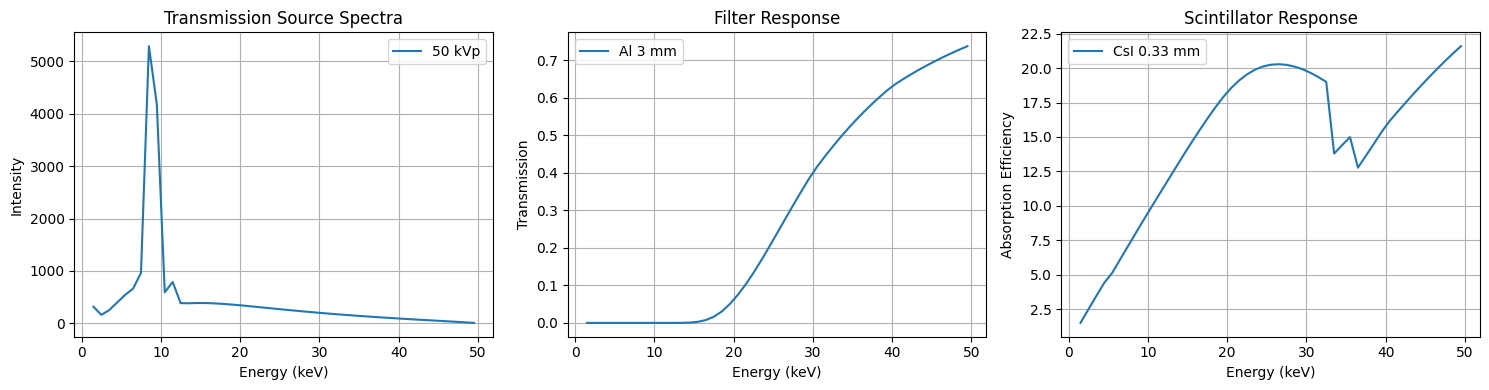

In [5]:
import matplotlib.pyplot as plt

# Plot setup
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Subplot 1: Source spectra for different voltages
axes[0].plot(ee, src_spec, label=f'{simkV} kVp')
axes[0].set_title('Transmission Source Spectra')
axes[0].set_xlabel('Energy (keV)')
axes[0].set_ylabel('Intensity')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Filter response
axes[1].plot(ee, gt_fltr, label=f'{fltr_mat} {fltr_th} mm')
axes[1].set_title('Filter Response')
axes[1].set_xlabel('Energy (keV)')
axes[1].set_ylabel('Transmission')
axes[1].legend()
axes[1].grid(True)

# Subplot 3: Scintillator response
axes[2].plot(ee, gt_det, label=f'{det_mat} {det_th} mm')
axes[2].set_title('Scintillator Response')
axes[2].set_xlabel('Energy (keV)')
axes[2].set_ylabel('Absorption Efficiency')
axes[2].legend()
axes[2].grid(True)

# Layout adjustment
plt.tight_layout()
plt.show()

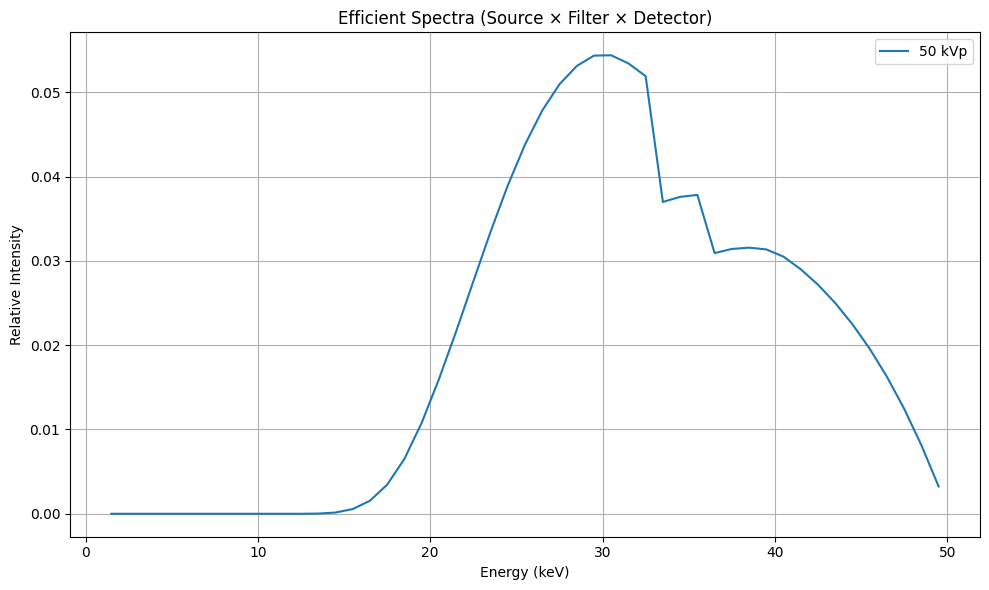

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ee, gt_srcs, gt_fltr, gt_det, and vol_list are already defined

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))
gt_spec_list = []
# Plot the efficient spectra for each voltage

# Calculate the efficient spectrum by multiplying with filter and detector responses. 
# Then do normalization.
efficient_spectrum = gt_src * gt_fltr * gt_det
gt_spec_list.append(efficient_spectrum)
# efficient_spectrum/=np.trapezoid(efficient_spectrum)
# Plot the efficient spectrum
plt.plot(ee, efficient_spectrum/np.trapezoid(efficient_spectrum), label=f'{simkV} kVp')

# Add labels and title
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Efficient Spectra (Source × Filter × Detector)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from xcal.chem_consts import get_lin_att_c_vs_E
sample_mats = ['V', 'Al', 'Ti', 'Mg']
mat_density = [density[formula] for formula in sample_mats]
lac_vs_E_list = [get_lin_att_c_vs_E(den, formula, ee) for den, formula in zip(mat_density, sample_mats)]
sample_thicknesses = np.linspace(0, 1, 100) # mm

# Attenuation Matrix, multiply effective spectrum can obtain tranmission measurement.
# (4*100)*145: 4 materials, 100 different thicknesses, at total 400 measurements and 145 energy bins.
spec_F = np.concatenate([np.exp(-sample_thicknesses[:,np.newaxis]@lac_vs_E[np.newaxis]) for lac_vs_E in lac_vs_E_list],axis=0)

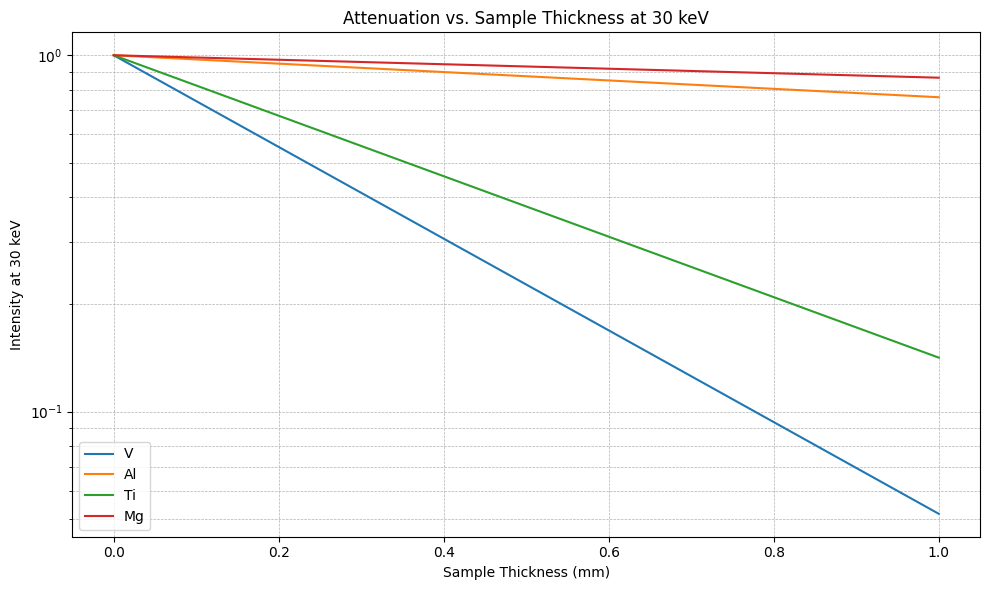

In [8]:
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))

# Plot the data for each sample material
for smid, sample_mat in enumerate(sample_mats):
    plt.plot(sample_thicknesses, spec_F[100*smid:100*(smid+1), 30], label=sample_mat)

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Sample Thickness (mm)')
plt.ylabel('Intensity at 30 keV')
plt.title('Attenuation vs. Sample Thickness at 30 keV')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [9]:
trans_list = []

# Obtain the converted energy, which is proportional to the detected visible light photons by the camera.
# gt_spec is the converted energy without an object.
# Notice that, trapezoid does the energy integration.
trans = np.trapezoid(spec_F * efficient_spectrum, ee, axis=-1) # Object scan
trans_0 = np.trapezoid(efficient_spectrum, ee, axis=-1) # Air scan value
# Add poisson noise.
# The noise level can be adjusted by changing the mas, the current-time product in the beginning of this tutorial.
trans_noise = np.random.poisson(trans).astype(np.float32)
trans_noise /= trans_0

# Store noisy transmission data.
trans_list.append(trans_noise)

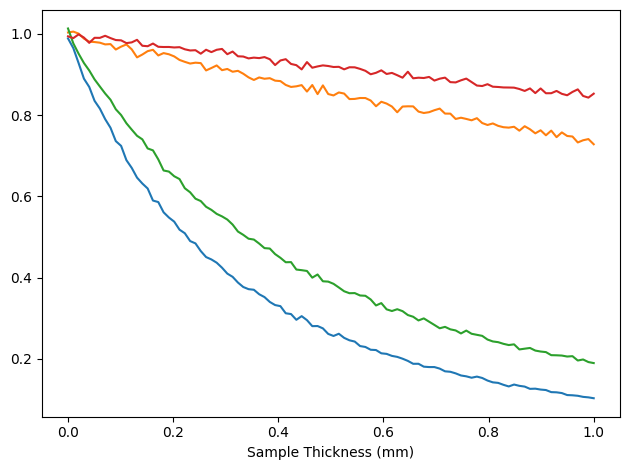

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Determine the number of cases
num_cases = len(gt_spec_list)

# Ensure axes is iterable
if num_cases == 1:
    axes = [axes]

# Plot data for each case

for smid, sample_mat in enumerate(sample_mats):
    # Extract the transmission data for the current sample and case
    transmission_data = trans_list[0][100 * smid : 100 * (smid + 1)]
    plt.plot(sample_thicknesses, transmission_data, label=sample_mat)


# Set the x-axis label for the bottom subplot
plt.xlabel('Sample Thickness (mm)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## B2. Estimation

In [11]:
from xcal.models import Reflection_Source, Scintillator
from xcal.defs import Material
from xcal.estimate import Estimate
from T04 import Filter

learning_rate = 0.001 # 0.01 for NNAT_LBFGS and 0.001 for Adam
max_iterations = 5000 # 5000 ~ 10000 would be enough
stop_threshold = 1e-6 
optimizer_type = 'Adam' # Can also use Adam.

# Use Spekpy to generate a source spectra dictionary.
takeoff_angles = np.linspace(5,45,11)
src_spec_list = []

for ta in takeoff_angles:
    # Generate the X-ray spectrum model with Spekpy for each voltage.
    s = sp.Spek(kvp=simkV, th=ta, dk=1, z=ct_info['SDD'], mas=mas_list, char=True)
    k, phi_k = s.get_spectrum(edges=False)  # Retrieve energy bins and fluence spectrum [Photons cm^-2 keV^-1]

    # Adjust the fluence for the detector pixel area.
    phi_k = phi_k * ((ct_info['psize'][0] / 10) * (ct_info['psize'][1] / 10))  # Convert pixel size from mm² to cm²

    # Initialize a zero-filled spectrum array with length max_simkV.
    src_spec = np.zeros(max_simkV-1)
    src_spec[:simkV-1] = phi_k  # Assign spectrum values starting from 1.5 keV

    # Add the processed spectrum for this voltage to the list.
    src_spec_list.append(src_spec)

src_spec_list = np.array(src_spec_list)
src_spec_list = src_spec_list.reshape((1,len(takeoff_angles),-1))
source = Reflection_Source(voltage=(50, None, None), takeoff_angle=(gt_takeoff_angle, None, None), single_takeoff_angle=True)
source.set_src_spec_list(ee, src_spec_list, [50], takeoff_angles)


# Not estimate filter and scintillator
psb_fltr_mat = [Material(formula='Al', density=2.702), 
                Material(formula='Cu', density=8.92)]
filter_1 = Filter(psb_fltr_mat, thickness=(5, 0, 10))
psb_scint_mat = [Material(formula='CsI', density=4.51)]
scintillator_1 = Scintillator(materials=psb_scint_mat, thickness=(0.33, None, None))

spec_models = [[source, filter_1, scintillator_1]]

Estimator = Estimate(ee)
# For each scan, add data and calculated forward matrix to Estimator.
Estimator.add_data(trans_list[0], spec_F, spec_models[0], weight=None)

# Fit data
Estimator.fit(learning_rate=learning_rate,
              max_iterations=max_iterations,
              stop_threshold=stop_threshold,
              optimizer_type=optimizer_type,
              loss_type='transmission',
              logpath=None,
              num_processes=1) # Parallel computing for multiple cpus.

Number of cases for different discrete parameters: 2


2025-05-25 12:51:53,737  - Start Estimation.
2025-05-25 12:51:53,759  - Initial cost: 2.388144e-03
2025-05-25 12:51:53,842  - Iteration: 50
2025-05-25 12:51:53,844  - Cost: 0.0015051235677674413
2025-05-25 12:51:53,844  - Filter_1_material: Material(formula='Al', density=2.702)
2025-05-25 12:51:53,844  - Filter_1_thickness: 4.509207248687744
2025-05-25 12:51:53,845  - Reflection_Source_1_voltage: 50.0
2025-05-25 12:51:53,845  - Reflection_Source_takeoff_angle: 13.0
2025-05-25 12:51:53,845  - Scintillator_2_material: Material(formula='CsI', density=4.51)
2025-05-25 12:51:53,845  - Scintillator_2_thickness: 0.33000001311302185
2025-05-25 12:51:53,845  - 
2025-05-25 12:51:53,936  - Iteration: 100
2025-05-25 12:51:53,938  - Cost: 0.0008214872796088457
2025-05-25 12:51:53,938  - Filter_1_material: Material(formula='Al', density=2.702)
2025-05-25 12:51:53,938  - Filter_1_thickness: 4.061138153076172
2025-05-25 12:51:53,938  - Reflection_Source_1_voltage: 50.0
2025-05-25 12:51:53,938  - Refle

In [12]:
Estimator.get_params()

{'Reflection_Source_1_voltage': tensor(50.),
 'Reflection_Source_takeoff_angle': tensor(13.),
 'Filter_1_material': Material(formula='Al', density=2.702),
 'Filter_1_thickness': tensor(2.9943, grad_fn=<ClampFunctionBackward>),
 'Scintillator_2_material': Material(formula='CsI', density=4.51),
 'Scintillator_2_thickness': tensor(0.3300)}

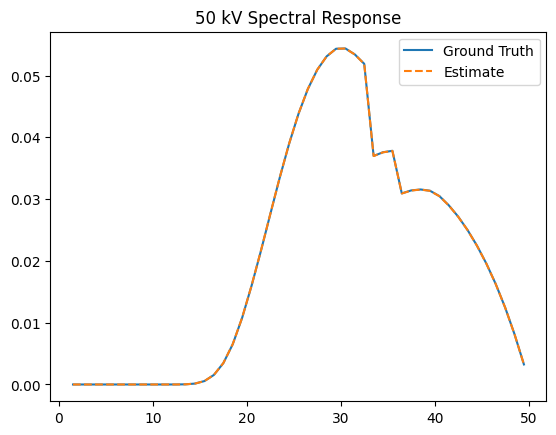

Ground Truth: 2.50, Estimated: 2.99


In [13]:
import torch
# Get the estimated effective response for each source voltage.
# Make sure to convert to numpy array from tensor before plotting.
est_sp = Estimator.get_spectra()

with torch.no_grad():
    plt.plot(ee, (gt_spec_list[0]/np.trapezoid(gt_spec_list[0],ee)),
            label='Ground Truth')
    es = est_sp[0].numpy()
    es /= np.trapezoid(es,ee)
    plt.plot(ee, es, '--', label='Estimate')

plt.legend()
plt.title(f'{simkV} kV Spectral Response')

fig.suptitle('Comparison of Ground Truth and Estimate')
plt.show()
print(f"Ground Truth: {gt_fltr_th:.2f}, Estimated: {Estimator.get_params()['Filter_1_thickness'].item():.2f}")